In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Set plot style
sns.set_style('whitegrid')

In [ ]:
# Download the dataset using the Kaggle Hub API
print("Downloading dataset...")
path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")

# Load the dataset from the downloaded path
file_path = f'{path}/heart_disease_uci.csv'
df = pd.read_csv(file_path)

print("Dataset downloaded and loaded successfully.")
print(f"Data shape: {df.shape}")
df.head()

Using Colab cache for faster access to the 'heart-disease-data' dataset.
Dataset downloaded and loaded successfully.
Data shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [ ]:
# Initial inspection
print("Dataset Information:")
df.info()

print("\nDescriptive Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB

Descriptive Statistics:
               id         age    trestbps        chol      thalch     oldpeak  \
co

In [ ]:
df.isnull().sum()

,0
id,0
age,0
sex,0
dataset,0
cp,0
trestbps,59
chol,30
fbs,90
restecg,2
thalch,55


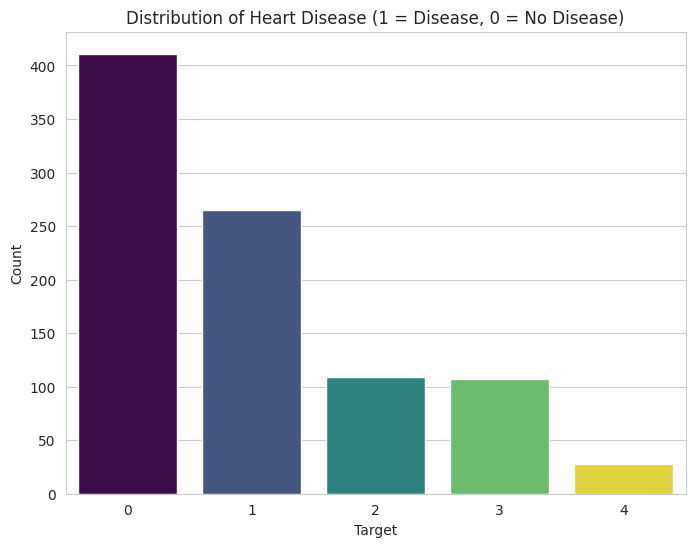

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='num', data=df, palette='viridis', hue='num', legend=False)
plt.title('Distribution of Heart Disease (1 = Disease, 0 = No Disease)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

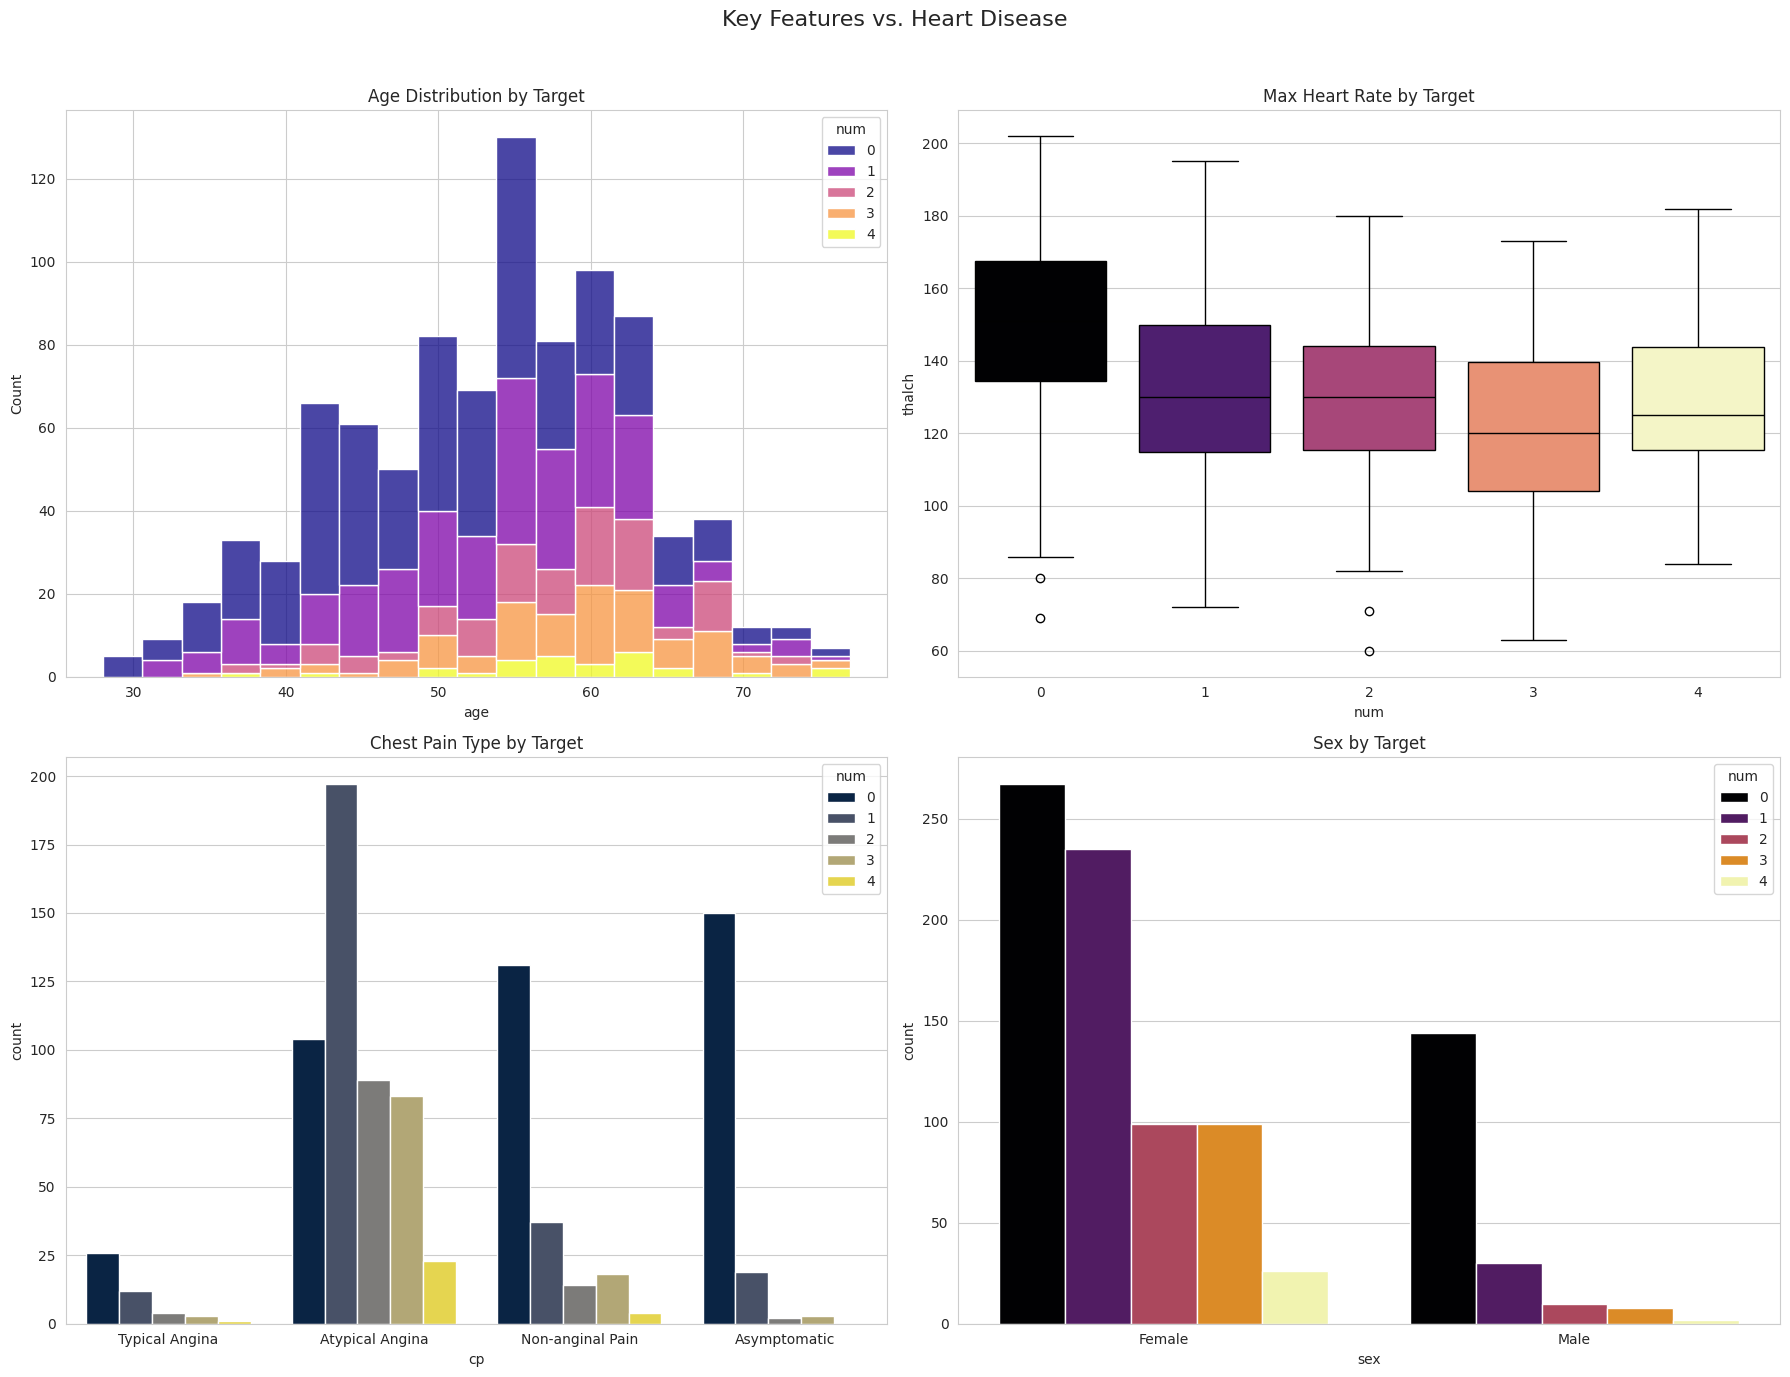

In [ ]:
# Let's visualize the relationship between key features and the target
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Key Features vs. Heart Disease', fontsize=16)

# Age vs. Target
sns.histplot(ax=axes[0, 0], data=df, x='age', hue='num', multiple='stack', palette='plasma').set_title('Age Distribution by Target')

# Max Heart Rate vs. Target
sns.boxplot(ax=axes[0, 1], data=df, x='num', y='thalch', palette='magma', hue='num', legend=False).set_title('Max Heart Rate by Target')

# Chest Pain Type vs. Target
cp_plot = sns.countplot(ax=axes[1, 0], data=df, x='cp', hue='num', palette='cividis')
cp_plot.set_title('Chest Pain Type by Target')
cp_plot.set_xticks(range(len(df['cp'].unique())))
cp_plot.set_xticklabels(['Typical Angina', 'Atypical Angina', 'Non-anginal Pain', 'Asymptomatic'])

# Sex vs. Target
sex_plot = sns.countplot(ax=axes[1, 1], data=df, x='sex', hue='num', palette='inferno')
sex_plot.set_title('Sex by Target')
sex_plot.set_xticks(range(len(df['sex'].unique())))
sex_plot.set_xticklabels(['Female', 'Male'])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

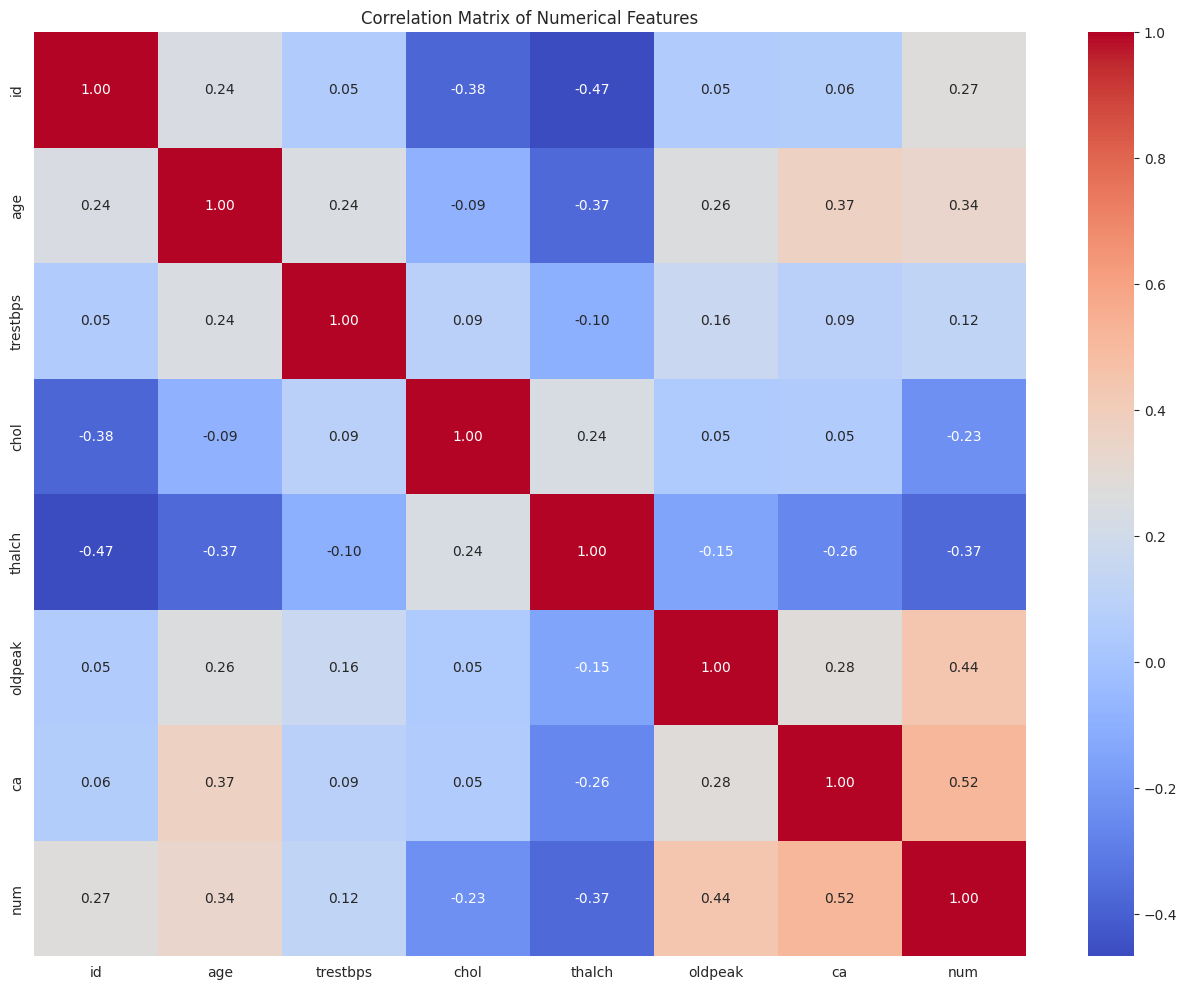

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(16, 12))
# Select only numerical columns for correlation calculation
numerical_df = df.select_dtypes(include=np.number)
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [ ]:
from sklearn.impute import SimpleImputer

# Define features (X) and target (y)
X = df.drop('num', axis=1)
y = df['num']

# Drop the 'id' and 'dataset' columns as they are not features
X = X.drop(['id', 'dataset'], axis=1)


# Identify categorical and numerical features
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Added imputation for categorical features
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Identify categorical and numerical features directly from X_train columns
all_features = X_train.columns.tolist()
categorical_features = [col for col in all_features if X_train[col].dtype == 'object']
numerical_features = [col for col in all_features if X_train[col].dtype != 'object']

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)


# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Create the Logistic Regression pipeline
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42))])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

Numerical features: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
Categorical features: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


In [ ]:
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

In [ ]:
from sklearn.svm import SVC

# Create the SVM pipeline
svm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', SVC(random_state=42))])

svm_pipeline.fit(X_train, y_train)
y_pred_svm = svm_pipeline.predict(X_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Create the KNN pipeline
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', KNeighborsClassifier())])

knn_pipeline.fit(X_train, y_train)
y_pred_knn = knn_pipeline.predict(X_test)

In [ ]:
print("--- Logistic Regression Performance ---")
print(classification_report(y_test, y_pred_lr, zero_division=0))

print("\n--- Random Forest Performance ---")
print(classification_report(y_test, y_pred_rf, zero_division=0))

print("\n--- Support Vector Machine (SVM) Performance ---")
print(classification_report(y_test, y_pred_svm, zero_division=0))

print("\n--- K-Nearest Neighbors (KNN) Performance ---")
print(classification_report(y_test, y_pred_knn, zero_division=0))

--- Logistic Regression Performance ---
              precision    recall  f1-score   support

           0       0.80      0.85      0.83        82
           1       0.49      0.57      0.53        53
           2       0.30      0.14      0.19        22
           3       0.16      0.19      0.17        21
           4       0.00      0.00      0.00         6

    accuracy                           0.58       184
   macro avg       0.35      0.35      0.34       184
weighted avg       0.55      0.58      0.56       184


--- Random Forest Performance ---
              precision    recall  f1-score   support

           0       0.74      0.84      0.79        82
           1       0.50      0.53      0.51        53
           2       0.23      0.14      0.17        22
           3       0.14      0.14      0.14        21
           4       0.00      0.00      0.00         6

    accuracy                           0.56       184
   macro avg       0.32      0.33      0.32       184
we

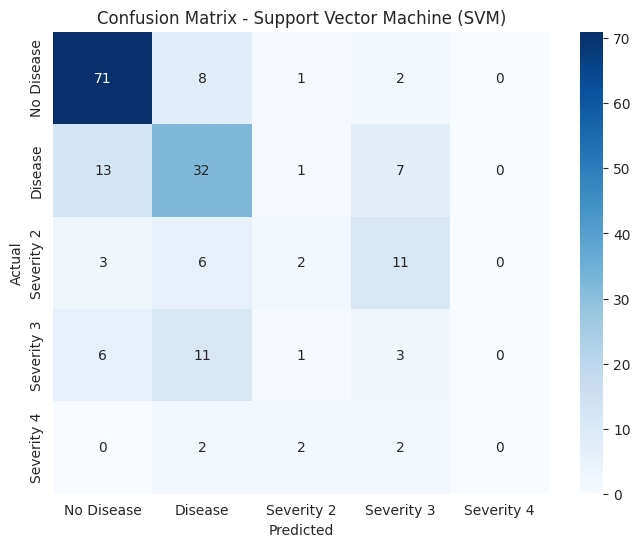

In [ ]:
# Visualize the confusion matrix for the best model (SVM)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease', 'Severity 2', 'Severity 3', 'Severity 4'], yticklabels=['No Disease', 'Disease', 'Severity 2', 'Severity 3', 'Severity 4'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Support Vector Machine (SVM)')
plt.show()

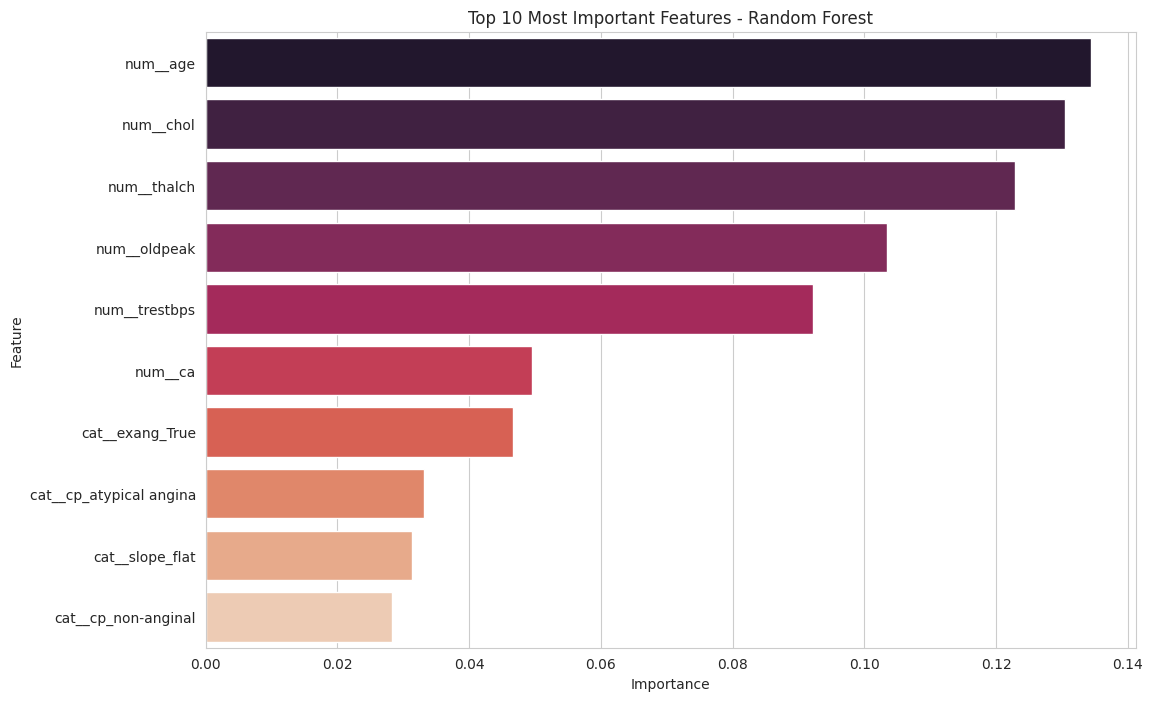

In [ ]:
# Extract feature names after one-hot encoding
feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Get feature importances from the trained model
importances = rf_pipeline.named_steps['classifier'].feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='rocket', hue='Feature', legend=False)
plt.title('Top 10 Most Important Features - Random Forest')
plt.show()

# Task
Perform exploratory data analysis (EDA) on the dataset.

In [ ]:
# Print the first 5 rows of the DataFrame
print("First 5 rows of the DataFrame:")
display(df.head())

# Print the information about the DataFrame
print("\nDataset Information:")
df.info()

# Print the descriptive statistics of the numerical columns
print("\nDescriptive Statistics:")
display(df.describe())

# Print the sum of missing values for each column
print("\nMissing Values per column:")
display(df.isnull().sum())

First 5 rows of the DataFrame:


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB

Descriptive Statistics:


,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000



Missing Values per column:


,0
id,0
age,0
sex,0
dataset,0
cp,0
trestbps,59
chol,30
fbs,90
restecg,2
thalch,55


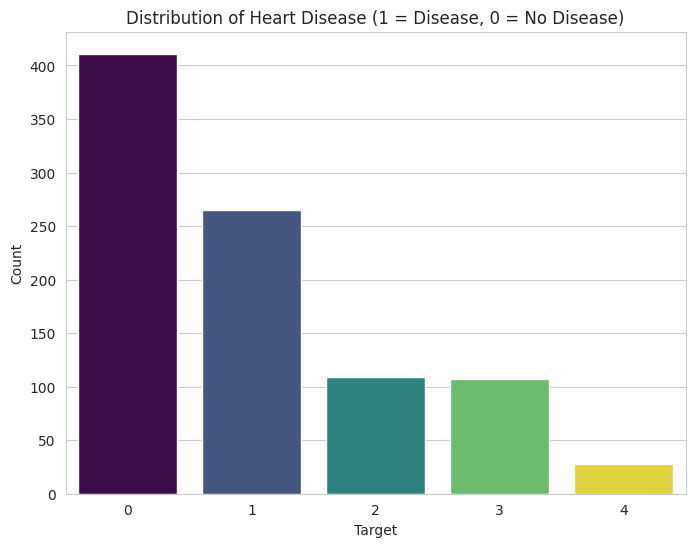

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='num', data=df, palette='viridis', hue='num', legend=False)
plt.title('Distribution of Heart Disease (1 = Disease, 0 = No Disease)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()


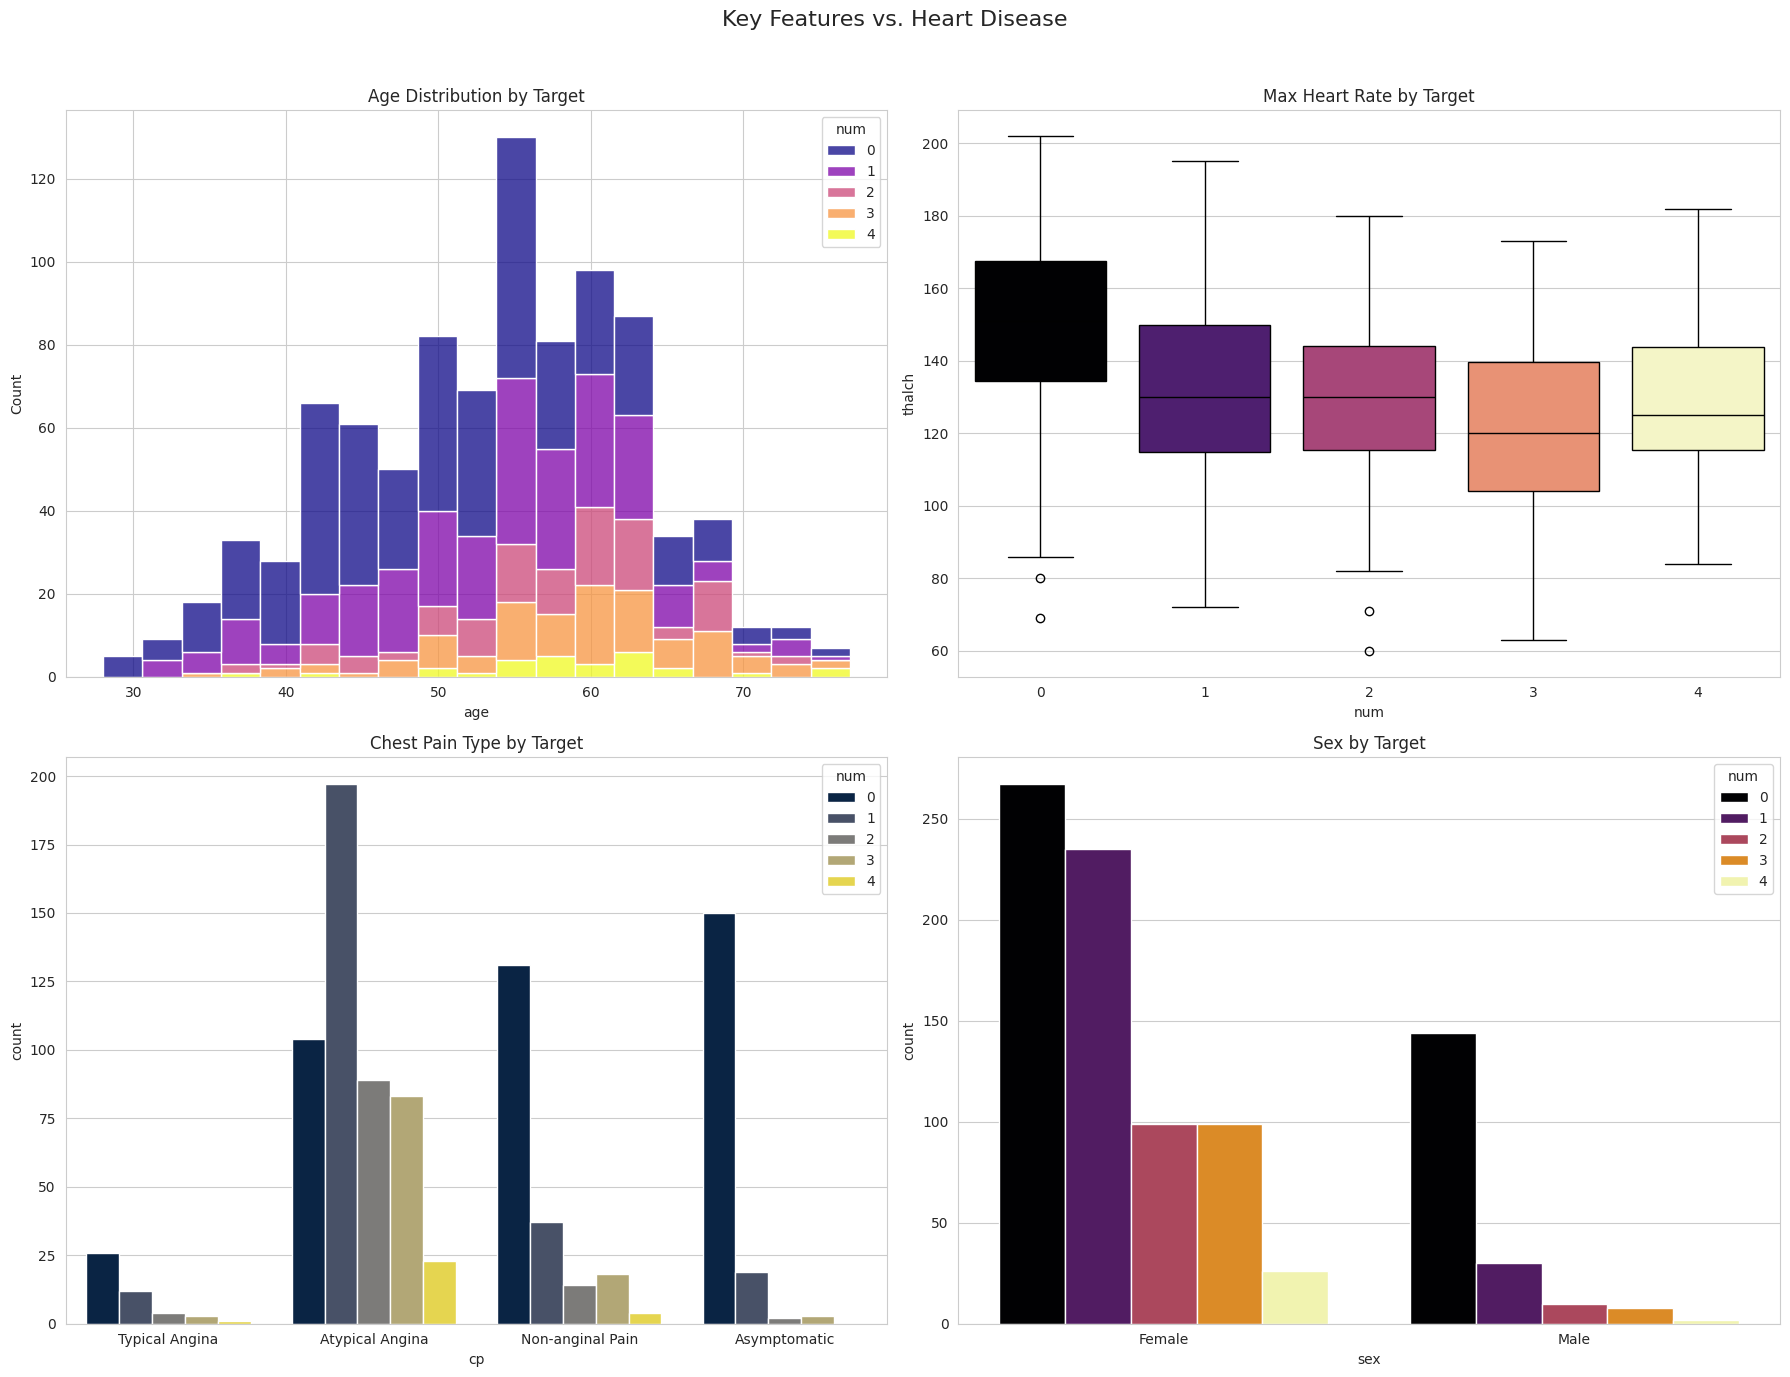

In [ ]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Key Features vs. Heart Disease', fontsize=16)

# Age vs. Target
sns.histplot(ax=axes[0, 0], data=df, x='age', hue='num', multiple='stack', palette='plasma').set_title('Age Distribution by Target')

# Max Heart Rate vs. Target
sns.boxplot(ax=axes[0, 1], data=df, x='num', y='thalch', palette='magma', hue='num', legend=False).set_title('Max Heart Rate by Target')

# Chest Pain Type vs. Target
cp_plot = sns.countplot(ax=axes[1, 0], data=df, x='cp', hue='num', palette='cividis')
cp_plot.set_title('Chest Pain Type by Target')
# Set meaningful labels for chest pain types
cp_plot.set_xticks(range(len(df['cp'].unique())))
cp_plot.set_xticklabels(['Typical Angina', 'Atypical Angina', 'Non-anginal Pain', 'Asymptomatic'])

# Sex vs. Target
sex_plot = sns.countplot(ax=axes[1, 1], data=df, x='sex', hue='num', palette='inferno')
sex_plot.set_title('Sex by Target')
# Set meaningful labels for sex
sex_plot.set_xticks(range(len(df['sex'].unique())))
sex_plot.set_xticklabels(['Female', 'Male'])

# Adjust layout and display the plots
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

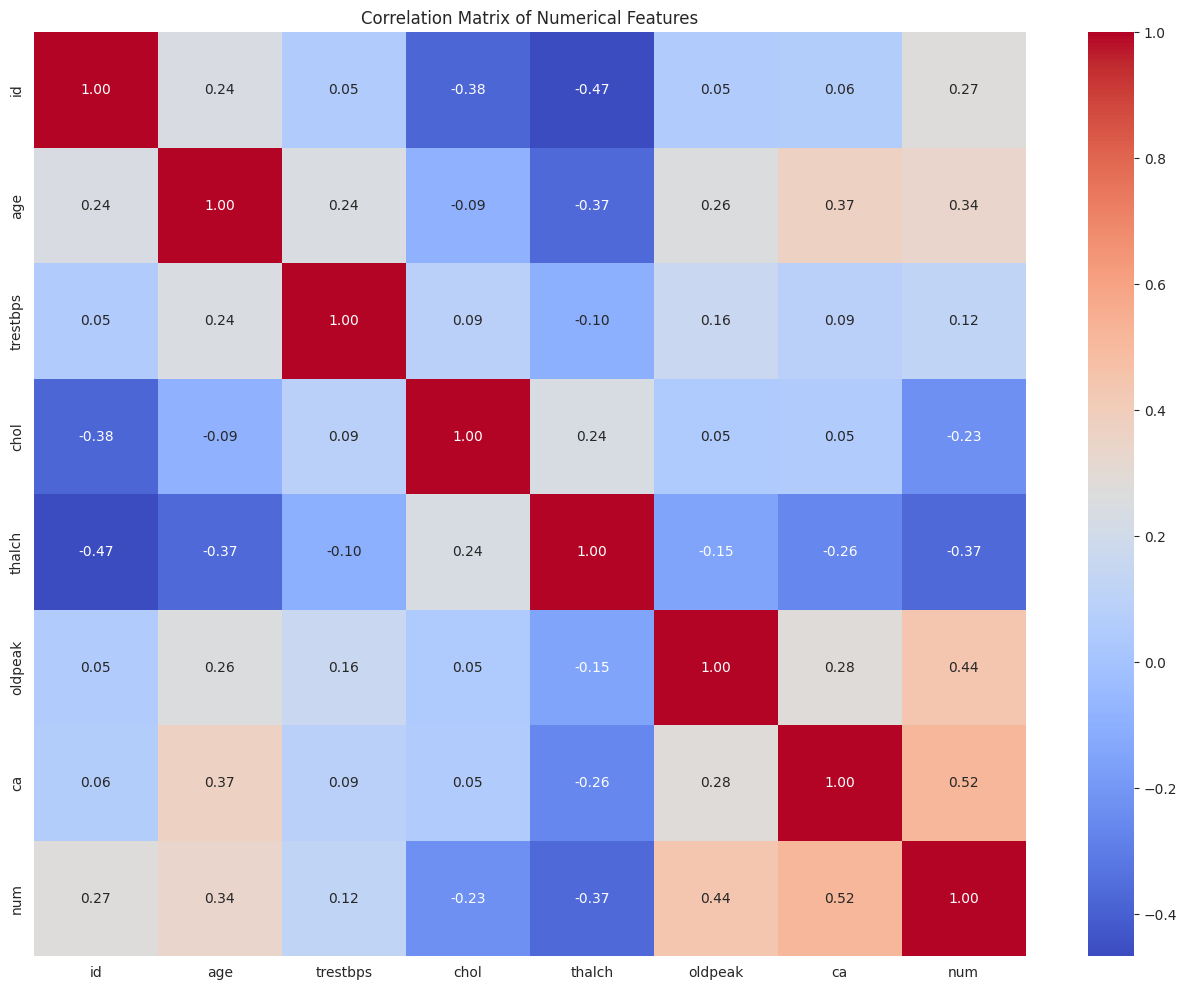

In [ ]:
# Select only numerical columns for correlation calculation
numerical_df = df.select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Create a heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Sum of missing values per column:
id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64


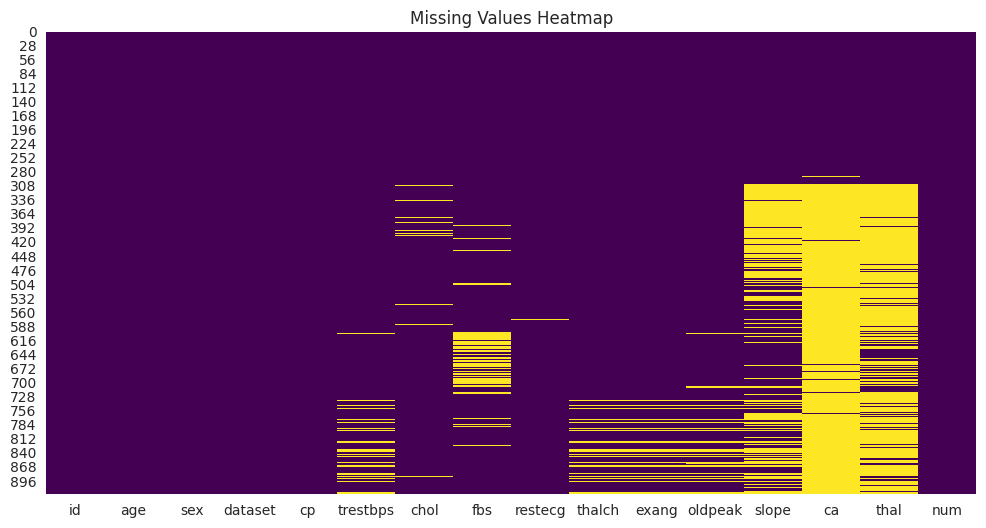


Imputation Strategy Discussion:
Based on the missing value counts and heatmap:
- Numerical columns ('trestbps', 'chol', 'thalch', 'oldpeak'): These have a moderate number of missing values.
  Strategy: Impute with the mean or median, depending on the distribution. Mean is chosen as a default reasonable strategy.
- Categorical columns ('fbs', 'restecg', 'exang', 'slope', 'thal'): These also have missing values, some significantly ('slope', 'thal').
  Strategy: Impute with the most frequent value (mode). This is a standard approach for categorical data.
- Column 'ca' (number of major vessels): Has a very high number of missing values (over 60%).
  Strategy: Given the high proportion of missing data, imputing 'ca' with a simple strategy like mean/median or mode might introduce significant bias. It might be better to drop this column or use more advanced imputation techniques if necessary. For this subtask, we will note that this column has significant missingness and will handle it in th

In [ ]:
# 1. Print the sum of missing values for each column
print("Sum of missing values per column:")
print(df.isnull().sum())

# 2. Visualize the missing values using a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# 3. Decide on an imputation strategy
print("\nImputation Strategy Discussion:")
print("Based on the missing value counts and heatmap:")
print("- Numerical columns ('trestbps', 'chol', 'thalch', 'oldpeak'): These have a moderate number of missing values.")
print("  Strategy: Impute with the mean or median, depending on the distribution. Mean is chosen as a default reasonable strategy.")
print("- Categorical columns ('fbs', 'restecg', 'exang', 'slope', 'thal'): These also have missing values, some significantly ('slope', 'thal').")
print("  Strategy: Impute with the most frequent value (mode). This is a standard approach for categorical data.")
print("- Column 'ca' (number of major vessels): Has a very high number of missing values (over 60%).")
print("  Strategy: Given the high proportion of missing data, imputing 'ca' with a simple strategy like mean/median or mode might introduce significant bias. It might be better to drop this column or use more advanced imputation techniques if necessary. For this subtask, we will note that this column has significant missingness and will handle it in the preprocessing steps by including it in the numerical features where SimpleImputer(strategy='mean') is applied, acknowledging the potential limitation.")

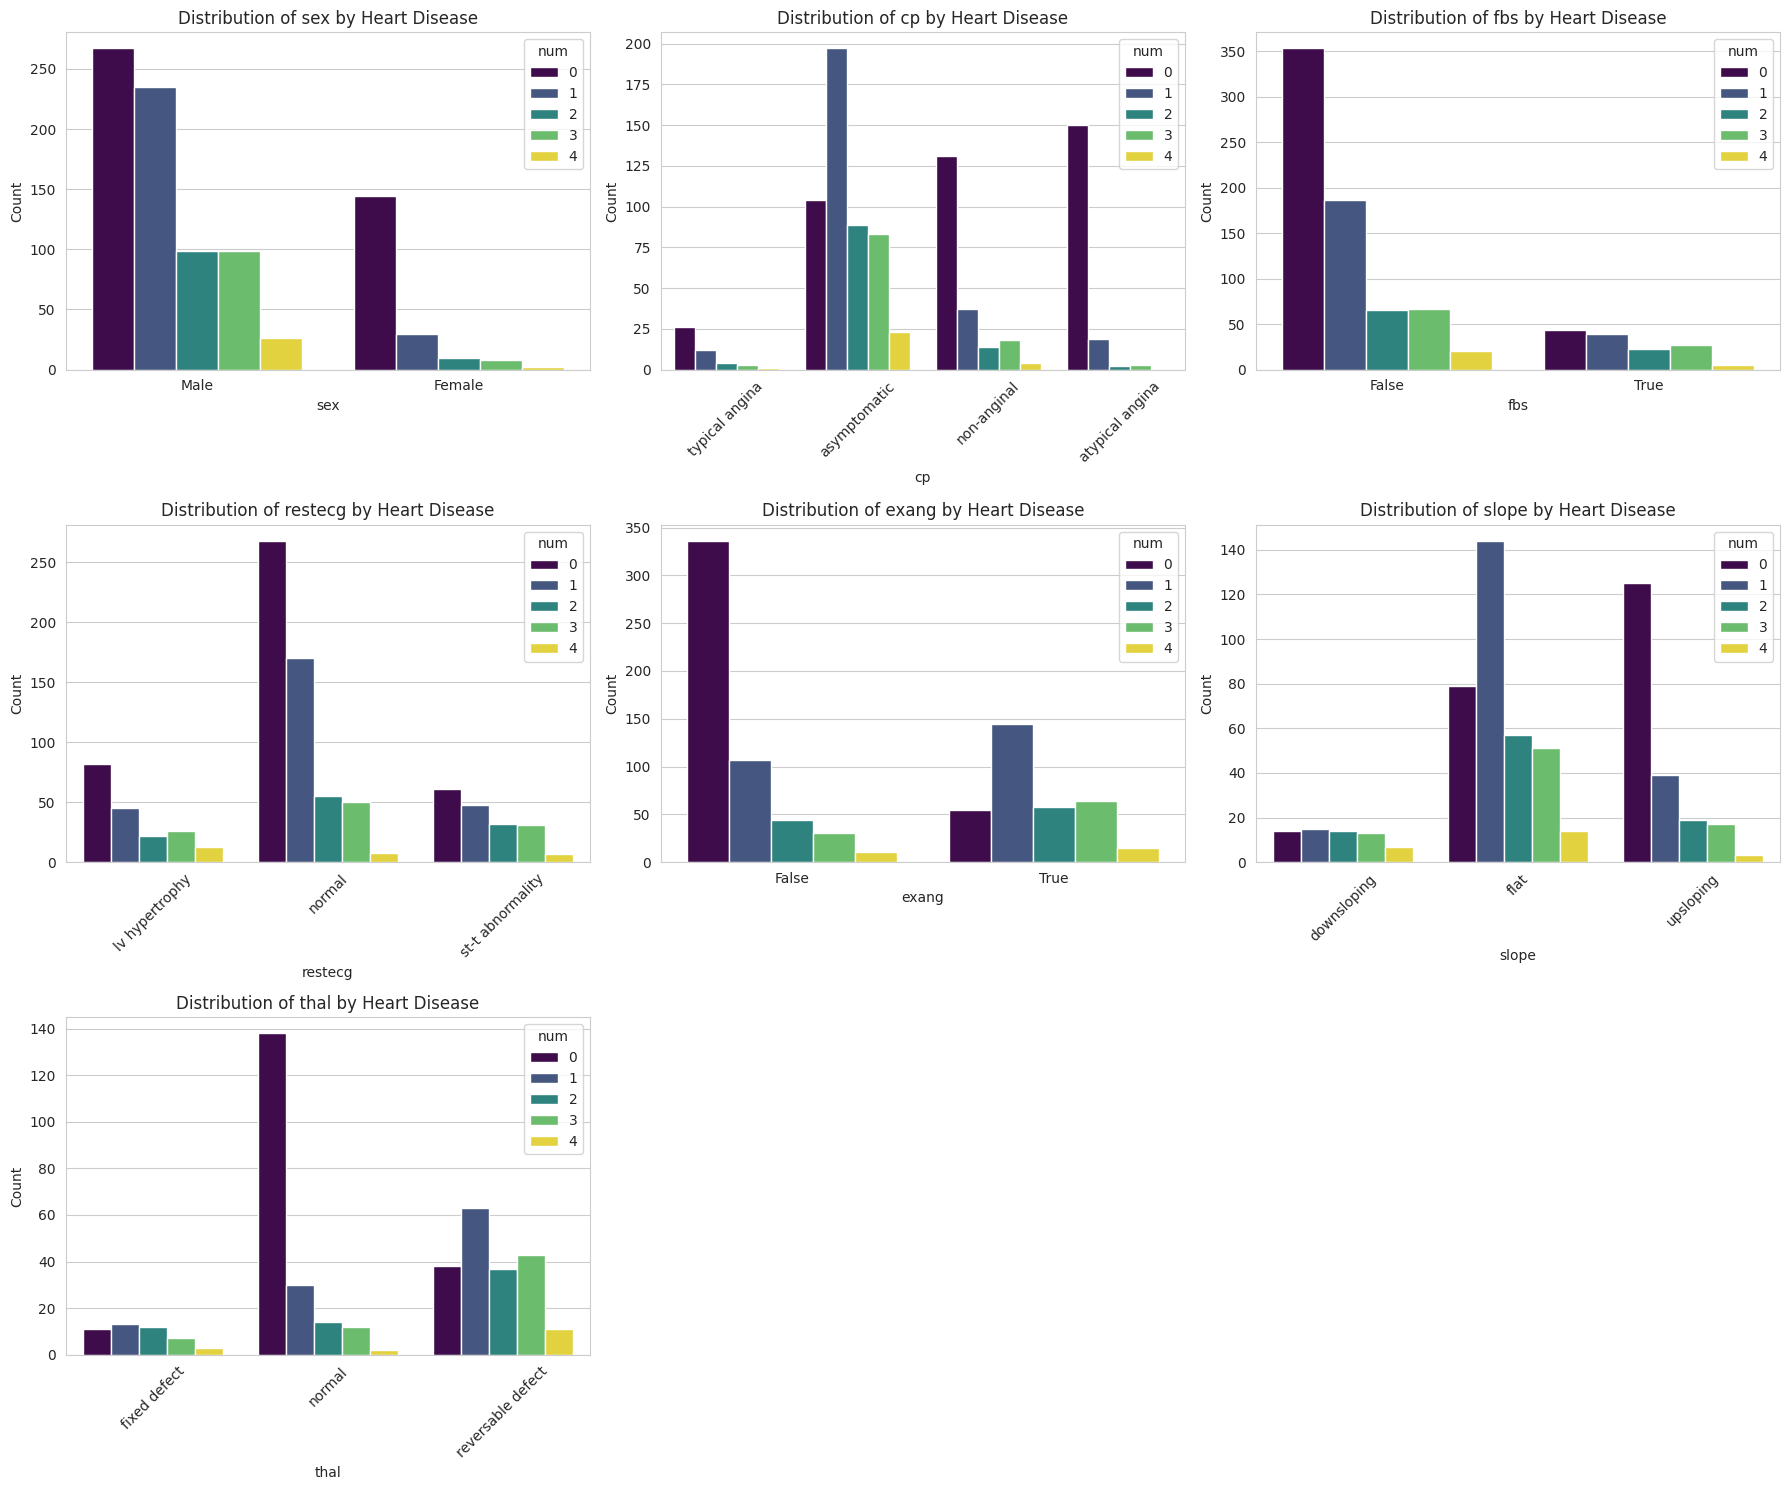

In [ ]:
# Identify categorical features
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# Determine the number of rows and columns for subplots
n_features = len(categorical_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

# Create a figure and a set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))
axes = axes.flatten() # Flatten the array of axes for easy iteration

# Iterate through categorical features and create count plots
for i, feature in enumerate(categorical_features):
    sns.countplot(ax=axes[i], data=df, x=feature, hue='num', palette='viridis')
    axes[i].set_title(f'Distribution of {feature} by Heart Disease')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    if feature in ['cp', 'restecg', 'slope', 'thal']: # Rotate x-axis labels for readability if needed
        axes[i].tick_params(axis='x', rotation=45)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Summary:**

Data Analysis Key Findings
The dataset contains 920 entries and includes numerical and object (likely categorical) data types.

Columns ca and thal have a significant number of missing values (611 and 486 respectively), followed by slope (309).

Numerical features like trestbps have a minimum value of 0, which might warrant further investigation.

The target variable num (heart disease diagnosis) is distributed across values 0 to 4, suggesting it might not be a simple binary classification target without transformation.

Visualizations indicate potential relationships between the target variable and features like age, sex, chest pain type (cp), and maximum heart rate (thalch). For example, certain chest pain types appear more frequently associated with heart disease.

The correlation matrix revealed the relationships between numerical features, providing insights for potential feature selection or understanding multicollinearity.

**Insights or Next Steps**

Address the missing values using the planned imputation strategies (mean for numerical, mode for categorical) or consider more advanced techniques, especially for ca and thal due to high missingness.

Clarify the meaning of the different numerical values in the target variable (num) and determine if it should be binarized (e.g., 0 for no disease, >0 for disease) for a binary classification task.

